In [ ]:
!pip install datasets vmdpy tensorflow scikit-learn

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from datasets import load_dataset

In [ ]:
SEQ_LENGTH = 24
TRAIN_RATIO = 0.97

TARGET_COL = "value"

WIND_FEATURES = [
    "windspeed_10m",
    "winddirection_10m",
    "windspeed_100m",
    "winddirection_100m",
    "windgusts_10m",

    "temperature_2m",
    "dewpoint_2m",
    "relativehumidity_2m",
    "surface_pressure",

    "cloudcover",
    "cloudcover_low",
    "cloudcover_mid",
    "cloudcover_high",

    "sin_doy",
    "cos_doy",
    "sin_time",
    "cos_time",

    "wind_turbine_count",

    "value_lag1",
    "value_lag2",
    "value_lag3",
]

In [ ]:
dataset = load_dataset("wachawich/REG-Forecasting_v2")
df = dataset["train"].to_pandas()

In [ ]:
df_wind  = df[df["fueltype"] == 2].copy().reset_index(drop=True)

df_wind["value_lag1"] = df_wind["value"].shift(1).fillna(0)
df_wind["value_lag2"] = df_wind["value"].shift(2).fillna(0)
df_wind["value_lag3"] = df_wind["value"].shift(3).fillna(0)

In [ ]:
def build_lstm_model(seq_length, num_features):
    optimizer = 'adam'
    model = Sequential([
        tf.keras.Input(shape=(seq_length, num_features)),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.2),
        Bidirectional(LSTM(32, return_sequences=False)),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1),
    ])
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [ ]:
def create_sequences(features, target, seq_length):
    X, y = [], []
    for i in range(len(target) - seq_length):
        X.append(features[i : i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

In [ ]:
def prepare_lstm_data(df_sub, feature_cols, label_name):
    print("\n" + "="*40)
    print(f"  Preparing data for LSTM - {label_name}")
    print("="*40)

    df_local = df_sub[[TARGET_COL] + feature_cols].copy()

    print(f"[{label_name}] shape after select+clean: {df_local.shape}")
    print(
        f"[{label_name}] target stats: "
        f"min={df_local[TARGET_COL].min():.2f}, "
        f"max={df_local[TARGET_COL].max():.2f}, "
        f"mean={df_local[TARGET_COL].mean():.2f}"
    )

    features_all = df_local[feature_cols].values.astype(float)

    target_raw = df_local[TARGET_COL].values.astype(float)
    target_raw = np.clip(target_raw, a_min=0.0, a_max=None)
    target = target_raw.reshape(-1, 1)

    T_len = len(df_local)
    train_size = int(T_len * TRAIN_RATIO)

    print(
        f"[{label_name}] Total length: {T_len}, "
        f"Train: {train_size}, Test: {T_len - train_size}"
    )

    X_train_raw = features_all[:train_size]
    X_test_raw  = features_all[train_size:]

    y_train_raw = target[:train_size]
    y_test_raw  = target[train_size:]

    scaler_x = MinMaxScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_x.fit_transform(X_train_raw)
    X_test_scaled  = scaler_x.transform(X_test_raw)

    y_train_scaled = scaler_y.fit_transform(y_train_raw)
    y_test_scaled  = scaler_y.transform(y_test_raw)

    X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
    X_test,  y_test  = create_sequences(X_test_scaled,  y_test_scaled,  SEQ_LENGTH)

    print(f"[{label_name}] X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"[{label_name}] X_test : {X_test.shape},  y_test : {y_test.shape}")

    # type ให้พร้อม train / evaluate
    X_train = X_train.astype("float32")
    y_train = y_train.astype("float32")
    X_test  = X_test.astype("float32")
    y_test  = y_test.astype("float32")

    full_actual = target_raw.reshape(-1, 1)

    return {
        "X_train": X_train,
        "y_train": y_train,
        "X_test": X_test,
        "y_test": y_test,
        "scaler_x": scaler_x,
        "scaler_y": scaler_y,
        "target_raw": target_raw,
        "train_size": train_size,
        "full_actual": full_actual,
    }

In [ ]:
def train_lstm(X_train, y_train, X_test, y_test, label_name):
    print("\n" + "="*40)
    print(f"  Training LSTM for {label_name}")
    print("="*40)

    model = build_lstm_model(SEQ_LENGTH, X_train.shape[2])

    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=64,
        validation_data=(X_test, y_test),
        verbose=1
    )

    return model, history

In [ ]:
def evaluate_lstm(
    model,
    X_train, y_train,
    X_test, y_test,
    scaler_y,
    target_raw,
    train_size,
    label_name,
    plot=True
):
    pred_scaled = model.predict(X_test)
    pred = scaler_y.inverse_transform(pred_scaled)
    actual = scaler_y.inverse_transform(y_test)

    train_pred_scaled = model.predict(X_train)
    train_pred = scaler_y.inverse_transform(train_pred_scaled)

    pred_flat = pred.reshape(-1, 1)
    actual_flat = actual.reshape(-1, 1)

    cal = LinearRegression()
    cal.fit(pred_flat, actual_flat)

    pred_cal = cal.predict(pred_flat)

    full_actual = target_raw.reshape(-1, 1)
    trainPredictPlot = np.full_like(full_actual, np.nan, dtype=float)
    testPredictPlot  = np.full_like(full_actual, np.nan, dtype=float)

    trainPredictPlot[SEQ_LENGTH:train_size, 0] = train_pred.flatten()

    test_start_idx = train_size + SEQ_LENGTH
    testPredictPlot[test_start_idx:test_start_idx + len(pred_cal), 0] = pred_cal.flatten()

    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))

    print(f"\n[{label_name}] MAE  (total): {mae:.4f}")
    print(f"[{label_name}] RMSE (total): {rmse:.4f}")

    if plot:
        plt.figure(figsize=(14, 5))
        plt.plot(full_actual, label=f"{label_name} Actual", linewidth=2)
        plt.plot(trainPredictPlot, label=f"{label_name} Train Forecast", linestyle="--")
        plt.plot(testPredictPlot, label=f"{label_name} Test Forecast", linestyle="--")
        plt.title(f"{label_name} - LSTM")
        plt.xlabel("Time (all samples)")
        plt.ylabel("Power")
        plt.legend()
        plt.grid(True)
        plt.show()

    result = {
        "mae": mae,
        "rmse": rmse,
        "actual": actual.flatten(),
        "pred": pred_cal.flatten(),
        "plot_actual": full_actual.flatten(),
        "plot_train": trainPredictPlot.flatten(),
        "plot_test": testPredictPlot.flatten(),
        "models": [{
            "name": label_name,
            "model": model,
            "scaler_y": scaler_y,
            "cal_model": cal,
        }],
    }

    return result



  Preparing data for LSTM - WIND
[WIND] shape after select+clean: (51563, 22)
[WIND] target stats: min=-2323.00, max=5922.00, mean=2048.89
[WIND] Total length: 51563, Train: 50016, Test: 1547
[WIND] X_train: (49992, 24, 21), y_train: (49992, 1)
[WIND] X_test : (1523, 24, 21),  y_test : (1523, 1)

  Training LSTM for WIND
Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 23s 23ms/step - loss: 0.3079 - val_loss: 0.1142
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.1177 - val_loss: 0.0764
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0962 - val_loss: 0.0851
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0920 - val_loss: 0.0770
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0885 - val_loss: 0.0681
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 0.0842 - val_loss: 0.0671
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.0813 - val_loss: 0.0845
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - lo

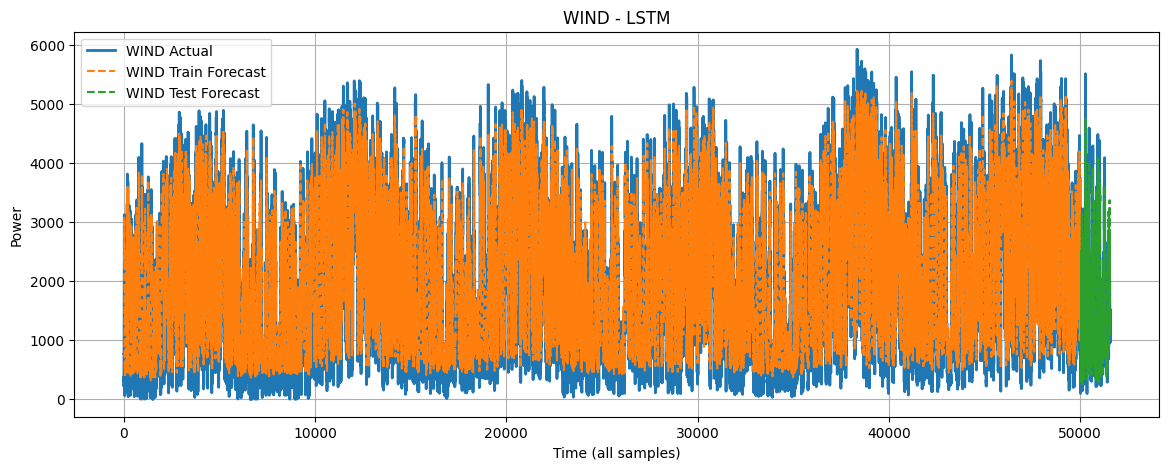

In [ ]:
df_sub = df_wind
feature_cols= WIND_FEATURES
label_name= "WIND"

prep = prepare_lstm_data(df_sub, feature_cols, label_name)

model, history = train_lstm(
  prep["X_train"], prep["y_train"],prep["X_test"],prep["y_test"], label_name
)

result = evaluate_lstm(
  model,
  prep["X_train"], prep["y_train"],
  prep["X_test"], prep["y_test"],
  prep["scaler_y"],
  prep["target_raw"],
  prep["train_size"],
  label_name,
  plot=True,
)

result["models"][0]["scaler_x"] = prep["scaler_x"]
scaler_x = result["models"][0]["scaler_x"]

In [ ]:
model.save("wind_lstm_model.keras")

In [ ]:
import joblib

joblib.dump(prep["scaler_x"], "wind_scaler_x.joblib")
joblib.dump(prep["scaler_y"], "wind_scaler_y.joblib")
print("Saved scalers.")

Saved scalers.


In [ ]:
def accuracy_overtime(actual, pred, threshold=100, smooth_window=None):
    actual = actual.flatten()
    pred   = pred.flatten()

    if smooth_window is not None and smooth_window > 1:
        import pandas as pd
        actual = pd.Series(actual).rolling(
            smooth_window, center=True, min_periods=1
        ).mean().values
        pred   = pd.Series(pred).rolling(
            smooth_window, center=True, min_periods=1
        ).mean().values

    actual_diff = np.diff(actual)
    pred_diff   = np.diff(pred)

    def to_dir(d):
        d = np.where(np.abs(d) < threshold, 0, d)
        return np.sign(d)

    actual_dir = to_dir(actual_diff)
    pred_dir   = to_dir(pred_diff)

    correct = np.sum(actual_dir == pred_dir)
    total   = len(actual_dir)
    acc     = correct / total if total > 0 else 0
    return acc * 100, actual_dir, pred_dir

In [ ]:
wind_acc, wind_actual_dir, wind_pred_dir = accuracy_overtime(
    result["actual"],
    result["pred"],
    threshold=100,
    smooth_window=5
)

print(f"Wind - Directional Accuracy: {wind_acc:.2f}%")

Wind - Directional Accuracy: 70.30%
